# 图像分类

在此项目中，将对 [Kaggle Dog vs Cat](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) 中的图片进行分类。该数据集包含猫狗。你需要预处理这些图片，然后用所有样本训练一个卷积神经网络。图片需要标准化（normalized），标签需要采用 one-hot 编码。你需要应用所学的知识构建卷积的、最大池化（max pooling）、丢弃（dropout）和完全连接（fully connected）的层。最后，你需要在样本图片上看到神经网络的预测结果。


## 获取数据

下载 [Kaggle Dog Vs Cat](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)。


In [1]:
"""
需要手动下载zip压缩包
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import zipfile


dog_vs_cat_dataset_folder_path = 'train'

zip_path = 'train.zip'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(zip_path):
    print('this not files in there')

if not isdir(dog_vs_cat_dataset_folder_path):
    with zipfile.ZipFile(zip_path) as zf:
        zf.extractall()
        zf.close()




## 探索数据

该数据集分成了两个部分：

train 数据集和 test 数据集。

训练过程中主要使用 train 数据集进行训练，然后通过test数据集进行测试。

从kaggle的题目中我们得知文件名中包含有dog 的为包含有狗的照片，包含有cat 的为包含有猫的照片。

运行下一个cell 得到的结果显示：
```
In the test floder , All Jpg file is 12500 ;
In the test floder , Dog jpg file is 0 ;
In the test floder , Cat Jpg file is 0 ;

In the train floder , All Jpg file is 25000 ;
In the train floder , Dog jpg file is 12500 ;
In the train floder , Cat Jpg file is 12500 ;

```
在测试数据集中图片是全部未标记的。需要我们训练模型之后进行结果输出。


## 获取文件夹下图片

传入floder 目录地址以读取文件，使用ratio 控制拆分数据为测试集和验证机的比率

### 随机化数据





In [1]:
import os
import numpy as np
import math
import tensorflow as tf

def get_all_files_name(floder,ratio=1):
    file_list = os.listdir(floder)
    file_list = list(map(lambda x : os.path.join(floder,x), file_list))

    dog_jpg = list(filter(lambda x : 'dog' in x  , file_list))
    cat_jpg = list(filter(lambda x : 'cat' in x  , file_list))

    print('In the %s floder , All Jpg file is %s ;' % (floder, len(file_list)))
    print('In the %s floder , Dog jpg file is %s ;' % (floder, len(dog_jpg)))
    print('In the %s floder , Cat Jpg file is %s ;' % (floder, len(cat_jpg)))
    
    
    image_list = np.hstack((cat_jpg, dog_jpg))
    label_list = np.hstack(([0] * len(cat_jpg), [1]*len(dog_jpg)))
    
    # 将数据打乱为随机数据
    temp = np.array([image_list, label_list])
    temp = temp.transpose()
    np.random.shuffle(temp) 
    
    all_image_list = temp[:, 0]
    all_label_list = temp[:, 1]
    
    #计算数据划分的训练集和验证集的分割点
    n_sample = len(all_label_list)
    n_val = math.ceil(n_sample*ratio) # number of validation samples
    n_train = n_sample - n_val # number of trainning samples
    
    #依据分割点划分数据
    tra_images = all_image_list[0:n_train]
    tra_labels = all_label_list[0:n_train]
    tra_labels = [int(float(i)) for i in tra_labels]
    val_images = all_image_list[n_train:-1]
    val_labels = all_label_list[n_train:-1]
    val_labels = [int(float(i)) for i in val_labels]
    
    return tra_images,tra_labels,val_images,val_labels
    
    
get_all_files_name('test')

tra_images,tra_labels,val_images,val_labels = get_all_files_name('train')

/usr/local/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In the test floder , All Jpg file is 12500 ;
In the test floder , Dog jpg file is 0 ;
In the test floder , Cat Jpg file is 0 ;
In the train floder , All Jpg file is 25000 ;
In the train floder , Dog jpg file is 12500 ;
In the train floder , Cat Jpg file is 12500 ;


## 实现预处理函数

### 标准化

对输入的图片进行标准化，然后返回 图片batch


In [2]:
def get_batch(image, label, image_W, image_H, batch_size, capacity):
    '''
    Args:
        image: list type
        label: list type
        image_W: image width
        image_H: image height
        batch_size: batch size
        capacity: the maximum elements in queue
    Returns:
        image_batch: 4D tensor [batch_size, width, height, 3], dtype=tf.float32
        label_batch: 1D tensor [batch_size], dtype=tf.int32
    '''
    # 如果想看到正常的图片，请注释掉（标准化）和 130行（image_batch = tf.cast(image_batch, tf.float32)）
    # 训练时，不要注释掉！
    
    image = tf.cast(image, tf.string)
    label = tf.cast(label, tf.int32)

    # make an input queue
    input_queue = tf.train.slice_input_producer([image, label])
    
    label = input_queue[1]
    image_contents = tf.read_file( input_queue[0])
    
    
    ## 图片标准化 注释这一行和下面cast可以看到正常图片
    image = tf.image.decode_jpeg(image_contents, channels=3)
    
    # 裁剪图片
    image = tf.image.resize_image_with_crop_or_pad(image, image_W, image_H)    
    image = tf.image.per_image_standardization(image)
    image_batch, label_batch = tf.train.batch([image, label],
                                                batch_size= batch_size,
                                                num_threads= 64, 
                                                capacity = capacity)
    label_batch = tf.reshape(label_batch, [batch_size])
    
    ## 图片向量转化
    image_batch = tf.cast(image_batch, tf.float32)
    
    return image_batch, label_batch

# 测试图片标准化函数

In [3]:
% matplotlib inline
import matplotlib.pyplot as plt

BATCH_SIZE = 2
CAPACITY = 256
IMG_W = 208
IMG_H = 208

train_dir = 'train/'
ratio = 0.2
tra_images, tra_labels, val_images, val_labels = get_all_files_name(train_dir, ratio)
tra_image_batch, tra_label_batch = get_batch(tra_images, tra_labels, IMG_W, IMG_H, BATCH_SIZE, CAPACITY)

In the train/ floder , All Jpg file is 25000 ;
In the train/ floder , Dog jpg file is 12500 ;
In the train/ floder , Cat Jpg file is 12500 ;


label: 0


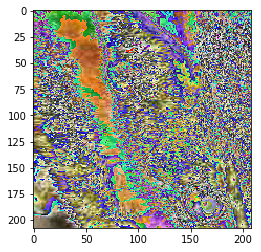

label: 1


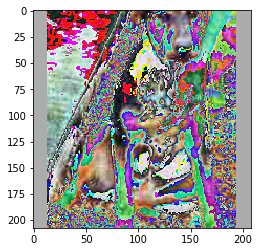

In [10]:
with tf.Session() as sess:
   i = 0
   coord = tf.train.Coordinator()
   threads = tf.train.start_queue_runners(coord=coord)
   
   try:
       while not coord.should_stop() and i<1:
           
           img, label = sess.run([tra_image_batch, tra_label_batch])
           
           # just test one batch
           for j in np.arange(BATCH_SIZE):
               print('label: %d' %label[j])
               plt.imshow(img[j,:,:,:])
               plt.show()
           i+=1
           
   except tf.errors.OutOfRangeError:
       print('done!')
   finally:
       coord.request_stop()
   coord.join(threads)

## 构建网络

对于该神经网络，你需要将每层都构建为一个函数。你看到的大部分代码都位于函数外面。要更全面地测试你的代码，我们需要你将每层放入一个函数中。这样使我们能够提供更好的反馈，并使用我们的统一测试检测简单的错误，然后再提交项目。

>**注意**：如果你觉得每周很难抽出足够的时间学习这门课程，我们为此项目提供了一个小捷径。对于接下来的几个问题，你可以使用 [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) 程序包中的类来构建每个层级，但是“卷积和最大池化层级”部分的层级除外。TF Layers 和 Keras 及 TFLearn 层级类似，因此很容易学会。

>但是，如果你想充分利用这门课程，请尝试自己解决所有问题，不使用 TF Layers 程序包中的任何类。你依然可以使用其他程序包中的类，这些类和你在 TF Layers 中的类名称是一样的！例如，你可以使用 TF Neural Network 版本的 `conv2d` 类 [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)，而不是 TF Layers 版本的 `conv2d` 类 [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d)。

我们开始吧！



In [11]:
def create_var(var_name, shape, dtype,init):
    return tf.get_variable(var_name, shape=shape, dtype=dtype,initializer=init)

def create_wb( weight_shape, biase_shape,stddev):
    weights = create_var('weights',
                         shape=weight_shape, 
                         dtype=tf.float32, 
                         init=tf.truncated_normal_initializer(stddev=stddev,dtype=tf.float32))
    biases = create_var('biases',
                         shape=biase_shape, 
                         dtype=tf.float32, 
                         init=tf.truncated_normal(0.1),
                       reuse=tf.AUTO_REUSE)
    return weights, biases


def get_pre_activation(images,weight_shape, biases_shape,stddev,strides):
    weights , biases = create_wb(weight_shape, biases_shape,stddev=stddev )
    conv = tf.nn.conv2d(images, weights, strides = strides,pandding='SAME')
    pre_activation = tf.nn.bias_add(conv,biases)
    return pre_activation
    


In [4]:
def inference(images, batch_size, n_classes):
    '''Build the model
    Args:
        images: image batch, 4D tensor, tf.float32, [batch_size, width, height, channels]
    Returns:
        output tensor with the computed logits, float, [batch_size, n_classes]
    '''
    #conv1, shape = [kernel size, kernel size, channels, kernel numbers]
    
    with tf.variable_scope('conv1') as scope:
        weights = tf.get_variable('weights', 
                                  shape = [3,3,3, 16],
                                  dtype = tf.float32, 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1,dtype=tf.float32))
        biases = tf.get_variable('biases', 
                                 shape=[16],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        conv = tf.nn.conv2d(images, weights, strides=[1,1,1,1], padding='SAME')
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name= scope.name)
    
    #pool1 and norm1   
    with tf.variable_scope('pooling1_lrn') as scope:
        pool1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1],strides=[1,2,2,1],
                               padding='SAME', name='pooling1')
        norm1 = tf.nn.lrn(pool1, depth_radius=4, bias=1.0, alpha=0.001/9.0,
                          beta=0.75,name='norm1')
    
    #conv2
    with tf.variable_scope('conv2') as scope:
        weights = tf.get_variable('weights',
                                  shape=[3,3,16,16],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.1,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[16], 
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        conv = tf.nn.conv2d(norm1, weights, strides=[1,1,1,1],padding='SAME')
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name='conv2')
    
    
    #pool2 and norm2
    with tf.variable_scope('pooling2_lrn') as scope:
        norm2 = tf.nn.lrn(conv2, depth_radius=4, bias=1.0, alpha=0.001/9.0,
                          beta=0.75,name='norm2')
        pool2 = tf.nn.max_pool(norm2, ksize=[1,3,3,1], strides=[1,1,1,1],
                               padding='SAME',name='pooling2')
    
    
    #local3
    with tf.variable_scope('local3') as scope:
        reshape = tf.reshape(pool2, shape=[batch_size, -1])
        dim = reshape.get_shape()[1].value
        weights = tf.get_variable('weights',
                                  shape=[dim,128],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[128],
                                 dtype=tf.float32, 
                                 initializer=tf.constant_initializer(0.1))
        local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)    
    
    #local4
    with tf.variable_scope('local4') as scope:
        weights = tf.get_variable('weights',
                                  shape=[128,128],
                                  dtype=tf.float32, 
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[128],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name='local4')
     
        
    # softmax
    with tf.variable_scope('softmax_linear') as scope:
        weights = tf.get_variable('softmax_linear',
                                  shape=[128, n_classes],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases', 
                                 shape=[n_classes],
                                 dtype=tf.float32, 
                                 initializer=tf.constant_initializer(0.1))
        softmax_linear = tf.add(tf.matmul(local4, weights), biases, name='softmax_linear')
    
    return softmax_linear

In [5]:
def losses(logits, labels):
    '''Compute loss from logits and labels
    Args:
        logits: logits tensor, float, [batch_size, n_classes]
        labels: label tensor, tf.int32, [batch_size]
        
    Returns:
        loss tensor of float type
    '''
    with tf.variable_scope('loss') as scope:
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits\
                        (logits=logits, labels=labels, name='xentropy_per_example')
        loss = tf.reduce_mean(cross_entropy, name='loss')
        tf.summary.scalar(scope.name+'/loss', loss)
    return loss

In [6]:
def evaluation(logits, labels):
  """Evaluate the quality of the logits at predicting the label.
  Args:
    logits: Logits tensor, float - [batch_size, NUM_CLASSES].
    labels: Labels tensor, int32 - [batch_size], with values in the
      range [0, NUM_CLASSES).
  Returns:
    A scalar int32 tensor with the number of examples (out of batch_size)
    that were predicted correctly.
  """
  with tf.variable_scope('accuracy') as scope:
      correct = tf.nn.in_top_k(logits, labels, 1)
      correct = tf.cast(correct, tf.float16)
      accuracy = tf.reduce_mean(correct)
      tf.summary.scalar(scope.name+'/accuracy', accuracy)
  return accuracy

In [7]:

def trainning(loss, learning_rate):
    '''Training ops, the Op returned by this function is what must be passed to 
        'sess.run()' call to cause the model to train.
        
    Args:
        loss: loss tensor, from losses()
        
    Returns:
        train_op: The op for trainning
    '''
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_op = optimizer.minimize(loss, global_step= global_step)
    return train_op



In [8]:
import os
import numpy as np
import tensorflow as tf


#%%

N_CLASSES = 2
IMG_W = 208  # resize the image, if the input image is too large, training will be very slow.
IMG_H = 208
RATIO = 0.2 # take 20% of dataset as validation data 
BATCH_SIZE = 64
CAPACITY = 2000
MAX_STEP = 6000 # with current parameters, it is suggested to use MAX_STEP>10k
learning_rate = 0.0001 # with current parameters, it is suggested to use learning rate<0.0001


#%%
def run_training():
    
    # you need to change the directories to yours.
    train_dir = 'train/'
    logs_train_dir = 'logs/train/'
    logs_val_dir = 'logs/val/'
    
    train, train_label, val, val_label = get_all_files_name(train_dir, RATIO)
    train_batch, train_label_batch = get_batch(train,
                                                  train_label,
                                                  IMG_W,
                                                  IMG_H,
                                                  BATCH_SIZE, 
                                                  CAPACITY)
    train_logits = inference(train_batch, BATCH_SIZE, N_CLASSES)
    train_loss = losses(train_logits, train_label_batch)        
    train_op = trainning(train_loss, learning_rate)
    train__acc = evaluation(train_logits, train_label_batch)
       
    summary_op = tf.summary.merge_all()
    sess = tf.Session()
    train_writer = tf.summary.FileWriter(logs_train_dir, sess.graph)
    saver = tf.train.Saver()
    
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    try:
        for step in np.arange(MAX_STEP):
            if coord.should_stop():
                    break
            _, tra_loss, tra_acc = sess.run([train_op, train_loss, train__acc])
               
            if step % 50 == 0:
                print('Step %d, train loss = %.2f, train accuracy = %.2f%%' %(step, tra_loss, tra_acc*100.0))
                summary_str = sess.run(summary_op)
                train_writer.add_summary(summary_str, step)
            
            if step % 2000 == 0 or (step + 1) == MAX_STEP:
                checkpoint_path = os.path.join(logs_train_dir, 'model.ckpt')
                saver.save(sess, checkpoint_path, global_step=step)
                
    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
    finally:
        coord.request_stop()
        
    coord.join(threads)
    sess.close()

In [9]:
run_training()

In the train/ floder , All Jpg file is 25000 ;
In the train/ floder , Dog jpg file is 12500 ;
In the train/ floder , Cat Jpg file is 12500 ;
Step 0, train loss = 0.69, train accuracy = 54.69%
Step 50, train loss = 0.69, train accuracy = 46.88%
Step 100, train loss = 0.69, train accuracy = 60.94%
Step 150, train loss = 0.68, train accuracy = 54.69%
Step 200, train loss = 0.69, train accuracy = 50.00%
Step 250, train loss = 0.66, train accuracy = 60.94%
Step 300, train loss = 0.68, train accuracy = 57.81%
Step 350, train loss = 0.62, train accuracy = 65.62%
Step 400, train loss = 0.62, train accuracy = 65.62%
Step 450, train loss = 0.58, train accuracy = 70.31%
Step 500, train loss = 0.63, train accuracy = 64.06%
Step 550, train loss = 0.58, train accuracy = 70.31%
Step 600, train loss = 0.63, train accuracy = 57.81%
Step 650, train loss = 0.59, train accuracy = 73.44%
Step 700, train loss = 0.54, train accuracy = 78.12%
Step 750, train loss = 0.50, train accuracy = 75.00%
Step 800, trai

In [15]:
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

def get_test_image():
    '''Randomly pick one image from training data
    Return: ndarray
    '''
    test_dir = 'test'
    file_list = os.listdir(test_dir)
    file_list = list(map(lambda x: os.path.join(test_dir, x), file_list))
    images = []
    for img_dir in file_list:
        image = Image.open(img_dir)
        #         plt.imshow(image)
        image = image.resize([208, 208])
        image = np.array(image)
        images.append((img_dir, image))
    return images

def evaluate_one_image(image_array):
    '''Test one image against the saved models and parameters
    '''

    # you need to change the directories to yours.

    with tf.Graph().as_default():
        BATCH_SIZE = 1
        N_CLASSES = 2

        image = tf.cast(image_array, tf.float32)
        image = tf.image.per_image_standardization(image)
        image = tf.reshape(image, [1, 208, 208, 3])
        logit = inference(image, BATCH_SIZE, N_CLASSES)

        logit = tf.nn.softmax(logit)

        x = tf.placeholder(tf.float32, shape=[208, 208, 3])

        # you need to change the directories to yours.
        logs_train_dir = 'logs/train/'

        saver = tf.train.Saver()

        with tf.Session() as sess:

            print("Reading checkpoints...")
            ckpt = tf.train.get_checkpoint_state(logs_train_dir)
            if ckpt and ckpt.model_checkpoint_path:
                global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
                saver.restore(sess, ckpt.model_checkpoint_path)
                print('Loading success, global_step is %s' % global_step)
            else:
                print('No checkpoint file found')

            prediction = sess.run(logit, feed_dict={x: image_array})
            max_index = np.argmax(prediction)

            if max_index == 0:
                print('This is a cat with possibility %.6f' % prediction[:, 0])
                pred = ('cat',prediction[:, 1][0])
            else:
                print('This is a dog with possibility %.6f' % prediction[:, 1])
                pred = ('dog',prediction[:, 1][0])
            return pred


In [12]:
all_images = get_test_image()

In [16]:
with open('result.txt', 'a+') as f:
    for img_dir, images in all_images:
        pred = evaluate_one_image(images)
        
        f.write(str(img_dir + ',' + '%s,%.6f' % (pred) + '\n'))
        
        

Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.808061
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.812779
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999953
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.849068
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999980
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibi

Loading success, global_step is 5999
This is a cat with possibility 0.998239
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999191
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.717519
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.971823
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.983661
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997379
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.600877
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.778763
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999180
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999893
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.989254
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.984430
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.895352
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.950599
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.548046
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996651
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.918595
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.724162
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999960
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.572411
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.957803
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.730952
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.983825
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.849238
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.961358
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.650630
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991235
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.978422
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996981
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.988281
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.997072
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999611
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998211
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.890523
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999935
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.873849
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.713493
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998909
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999889
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997371
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.982202
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999806
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.997442
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.807405
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.974250
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.877852
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999994
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.974676
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.997411
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990935
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.981138
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.805679
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993133
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994742
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.986469
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.937592
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.972972
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.618283
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996036
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.955349
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.993635
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998871
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.973838
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.933940
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997678
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993153
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.978333
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999788
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996718
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.977602
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.990243
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.915917
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.786736
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.827014
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991767
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999905
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.866225
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.668910
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.995253
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999325
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999567
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999254
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.813187
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.988116
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.866338
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999527
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999863
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997941
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.949451
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.715403
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.850532
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.870917
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.865466
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999857
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.884051
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.949756
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.903754
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997611
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.968520
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.899541
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996754
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.982162
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999346
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.985789
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998628
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999058
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.711581
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.881773
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.949044
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.650576
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.946354
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.991315
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.925094
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.622676
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.894973
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.904574
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.901865
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999354
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999418
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.996100
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.928055
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.968672
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.932930
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999959
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.986109
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.969810
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.978623
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993294
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.910222
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999887
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997190
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.997149
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999914
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997056
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.863704
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998897
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.939026
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.572122
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999900
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.971926
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.905453
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993716
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.987956
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.639158
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.792811
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.991361
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.860441
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.552669
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999986
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.748734
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.931326
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.698027
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.907688
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.934470
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.776950
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.988515
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995841
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998953
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.892780
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994148
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999022
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.994631
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.848651
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994935
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994255
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996559
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998609
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.987322
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.892889
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.980191
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.842614
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.653578
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.974733
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.562857
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.968207
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998441
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.823678
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.611865
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.988409
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.996954
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.988124
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.924350
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.799592
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.901764
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.637527
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.993958
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.960117
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.941251
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.817143
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.979351
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.873948
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.690637
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.939043
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999944
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998552
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998925
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.784832
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.996792
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995089
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.702465
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996816
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.799272
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.772713
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.983821
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.987050
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.592152
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.962794
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993914
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995283
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.998966
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.955598
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.980177
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.988004
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.814504
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.987544
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.992817
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.559589
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999144
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990056
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.744820
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.555450
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.788525
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991994
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993629
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.931728
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995799
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998993
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.708277
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.934818
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994689
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.965998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.660189
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.824858
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999409
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998894
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.860094
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998165
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996505
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.870484
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.997055
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.981532
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999973
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.969245
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.687557
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.900509
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.916477
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.914707
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999673
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.873460
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.919433
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.984352
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.848199
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.964692
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999412
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.580725
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996611
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.726307
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999688
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.864804
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997581
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.979865
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999909
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998785
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.865822
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.986489
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997308
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.973774
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.589379
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.970100
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.893379
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.886177
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.765434
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.914114
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995122
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.982242
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.970839
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.776350
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.717092
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.966903
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.874123
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.862205
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.998642
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.976574
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.641986
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.554566
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.851122
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.783417
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.994165
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.623929
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995385
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999839
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.976454
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.975224
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.988155
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998570
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995831
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.567633
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999656
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.582301
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.735469
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.987876
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.798980
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999222
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999765
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.988544
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.700465
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.811414
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.656581
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.916428
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.937989
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.982932
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.551767
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.992648
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.985982
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999376
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.980428
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.902209
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.998162
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999229
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.825480
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.902005
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.628265
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990430
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.979909
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.623556
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.962981
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991980
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996892
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999430
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.968584
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.932203
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.781982
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.968351
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.941369
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.547399
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.991368
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.549284
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996729
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.952261
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.981654
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.623023
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.592443
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999828
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997969
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.875906
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.972904
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999610
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.987513
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999480
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996472
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999644
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.614925
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.933945
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.991873
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.915641
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.965592
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.897214
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.981525
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.571686
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.623822
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993454
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.982281
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999438
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.664521
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.977950
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.963894
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.903174
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998395
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995702
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.659517
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.957346
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.985357
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.971809
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.895970
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999843
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.897858
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991074
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.743757
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.992956
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.956659
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998421
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.932531
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999930
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.517437
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.871195
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999330
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999710
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.680132
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995708
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.998496
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.950833
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.885439
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.512487
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.791025
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.960348
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.876234
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.976704
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999263
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994422
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.885646
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.947725
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.980509
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.975278
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.878150
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.910944
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.800292
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.949977
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.987595
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.938575
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.864393
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.963354
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.972837
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999468
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.995300
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998797
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.985741
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.977769
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.604986
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.981068
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.983926
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.771364
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.662640
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.966334
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.770914
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.920551
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.615632
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.938925
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.981285
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.532821
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993658
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.981772
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.994452
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.594597
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994608
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999721
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.989315
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.961195
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.967807
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.981781
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.910795
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997692
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.760677
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991898
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.859946
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.830811
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.958961
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.964293
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.825111
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.931714
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.778563
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999987
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.877251
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.936741
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.988623
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.995840
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991711
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.901170
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.824640
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.974671
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993988
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.564786
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994639
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990071
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.853826
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.703648
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.875110
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.567358
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995709
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.709361
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.963163
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.960348
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.813097
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.971913
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.978554
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.989255
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.878896
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.514403
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997778
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.756200
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.926878
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999890
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999431
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.525717
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.936033
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.730878
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.753040
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.982303
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999886
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.805232
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.938465
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.985682
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.774416
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.587355
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999730
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990043
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.966648
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.975329
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.974888
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998681
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.948793
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984988
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998646
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.997052
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999726
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998743
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.864825
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999288
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994559
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.809155
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.538262
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999345
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991941
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.927643
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.956114
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999850
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.586569
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.520280
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.558619
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999315
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.986125
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.920729
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.654684
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.713995
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998558
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997681
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.541920
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.704863
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999859
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994467
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.958875
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.688961
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.877888
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.523850
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.939268
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.893748
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999072
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.826917
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997624
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.979969
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.903357
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991274
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999186
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.985241
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.988455
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.680966
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.983039
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.622408
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.984572
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.941729
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997402
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.571781
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.982650
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.715038
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.981650
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.664830
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.826019
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999762
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.784971
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999005
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.985675
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.735890
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995633
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.574096
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999889
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.951016
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.987221
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999952
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.984335
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.919208
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.973902
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.933397
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999500
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999080
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.970712
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.597470
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.548608
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.906288
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.982073
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.977952
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.852989
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.998084
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.911492
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.987101
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.943162
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.985402
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.987624
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.953495
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999915
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.875042
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.934718
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.600583
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993025
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.951839
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984944
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.986508
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.775464
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.954914
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999870
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.857692
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.897586
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997443
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.948108
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.687963
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.964842
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.997839
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.801989
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.856193
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.981336
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.988732
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.983157
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.877373
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.923569
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.856764
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.852199
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999408
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.975159
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.561178
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.693381
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996864
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999967
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.843779
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.990436
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.930062
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997099
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.984282
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.906472
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.985778
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.616440
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.973317
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.898915
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.866159
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.974719
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.977544
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.879316
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999804
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.981812
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.931944
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.877908
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.590973
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.905723
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.738466
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.852001
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.881298
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.955407
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.959267
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.987928
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.935347
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.989508
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997847
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999419
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995631
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997702
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.826256
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998420
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.983742
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.980857
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.981318
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.723664
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.945791
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.945744
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.688454
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999934
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.747555
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.981758
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.971710
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.967694
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.952513
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999680
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996019
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.988810
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.981600
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984668
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.978653
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.517209
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999862
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999869
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.858769
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.985664
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.869038
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.740239
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.983533
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.965111
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.964554
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996561
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996320
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998451
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998146
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.996556
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992247
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999598
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996627
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.883357
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.950206
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.978716
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.618479
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.718866
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.957280
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.932171
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.966929
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.769188
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.681311
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997719
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.930616
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984563
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996159
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.995448
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.739708
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996562
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996231
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999784
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.955814
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.975255
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.849275
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.976201
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.865639
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997928
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.949497
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.888593
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997619
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.945104
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.870799
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.897568
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.968303
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.989648
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.535329
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.571891
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999737
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.955427
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.940820
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.643830
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.685276
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.991235
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.986427
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.988017
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992781
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.891549
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.550942
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997196
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.806667
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.688972
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.980831
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.814362
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999898
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991860
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.989187
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.643820
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997965
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.996065
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.891510
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.980467
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993430
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998490
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999918
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.993677
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.895889
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.936016
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.975347
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.743782
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.575041
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999904
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997988
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996506
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.959338
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.955456
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997816
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.992031
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998890
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994218
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.568127
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.827956
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.975621
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.968953
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.879922
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.939308
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.784004
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.849232
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996575
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.751982
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.512468
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.988922
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.826188
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.980057
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.831365
Reading c

Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.982743
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.935782
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.684783
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984590
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997404
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibi

Loading success, global_step is 5999
This is a dog with possibility 0.990973
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.620888
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.545163
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.754001
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.887082
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.570434
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.838986
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.935696
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.871266
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998032
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.802421
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.988494
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.991243
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.989562
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996025
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997656
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.643803
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.610416
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999527
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.562635
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.969999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.736664
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998594
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.984631
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994455
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.968297
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994392
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995765
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.630319
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.928922
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998959
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.978604
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998148
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.991732
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.856408
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.762085
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.986068
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997548
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.871374
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.837042
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999224
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.964421
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.800531
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.622656
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.988768
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.942511
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998671
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.947168
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.957784
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.694692
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.960660
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.890422
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.980853
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.991224
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.563056
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.952664
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.920998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.968857
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996676
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.996259
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.975811
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999033
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.982084
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.756067
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996629
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.985546
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.992290
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992594
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997341
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.755735
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.932769
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999045
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.843920
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994886
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.945984
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995026
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998784
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999768
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998513
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.941976
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.973024
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998930
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.893088
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.997008
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.924033
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.976588
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.839595
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.793296
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.955841
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.985531
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.969404
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.796730
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997015
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.838835
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.866662
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.997220
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.718110
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998869
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990012
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.543851
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.580042
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.980944
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994960
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997599
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.873767
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.872206
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.930401
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.869227
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.964955
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.679289
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993751
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997841
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.622881
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.911062
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997396
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.547336
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995290
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.989360
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992690
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.977689
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.951547
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998208
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991353
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984671
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.990480
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.925683
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.948314
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.721396
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.957021
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999909
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.998072
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.943685
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.798556
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999989
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.807152
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.542403
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.910584
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.640917
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990206
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.722059
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.836387
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991762
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.772484
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999216
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998859
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.896250
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.983437
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992096
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.938931
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.897307
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.954612
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.841369
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998164
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996923
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.969491
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999781
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.989942
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999613
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.960472
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.600489
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.854316
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996330
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994014
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.924199
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.975915
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991379
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.956401
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999714
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.924901
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.977619
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999574
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984257
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.948104
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.983600
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998124
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999659
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.977564
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997777
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999137
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997438
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.645025
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.668672
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.587053
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.796759
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.928887
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.968682
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999936
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.987502
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.753998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.641876
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.889114
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.982758
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.951100
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.938966
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.939729
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.888906
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999389
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.807707
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.963520
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999745
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.859914
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.983165
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.543297
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.832112
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.978521
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996510
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996244
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.834746
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.963276
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.867137
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998815
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.957111
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.937203
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.937315
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.986354
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999416
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.946697
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.989947
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.864989
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.961345
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.566009
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997730
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.981925
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.977061
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.924911
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.925129
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999571
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.515620
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.855088
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999921
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.527719
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994514
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.975692
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998150
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.678492
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.834487
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.967226
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.973072
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.990998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.974917
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997692
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998556
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.586595
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.652786
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.837248
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.945661
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992312
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995537
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.981310
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.969240
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.998437
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984547
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.680103
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994879
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.903034
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.983826
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.983526
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998919
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.988071
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999292
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997663
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.923924
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.994807
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.986095
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.782162
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999652
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999804
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.978287
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.914662
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996112
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.944151
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993686
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999881
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999879
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.994298
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.921129
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.975317
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991598
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999809
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.616181
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.986986
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.652577
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.796890
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.505070
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999116
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.983079
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.978081
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.603683
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.885201
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.979815
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.761822
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999716
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.693723
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.732111
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.916599
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.986530
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.577538
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.945101
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.996579
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.946486
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999521
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.979584
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.891362
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.940438
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.987567
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984684
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.686126
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996014
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.960950
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999404
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.986377
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.822817
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.879833
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.952802
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999462
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.603905
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.951427
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.975662
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.868330
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999994
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992809
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.972474
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.996332
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.955008
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997596
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.759773
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.851355
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984760
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.989248
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.902889
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991906
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984923
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.986854
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.986610
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.773810
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.890966
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.933755
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.898206
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997004
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.961228
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.905293
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.524658
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995098
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999882
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.975934
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998360
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.973366
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996008
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996666
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994133
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.976453
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997358
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999936
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997030
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995564
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990051
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999101
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.614481
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.923564
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.986438
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995076
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.900584
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.671016
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.907498
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999745
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998268
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994659
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996951
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997708
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.843324
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.908280
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.881179
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.981898
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.982276
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990194
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.954605
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.945526
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992687
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.963734
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.613236
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999666
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991373
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.973383
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992627
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.896431
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.979937
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.859061
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.857771
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.772175
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.988431
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.984341
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.952286
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.977696
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992484
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.958921
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.964623
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997375
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.871667
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.610820
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.983923
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.956522
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.560686
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995901
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.806640
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.645664
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.733916
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.892150
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995002
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.865334
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999210
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.775501
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.974595
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.996390
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999040
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.754218
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.960236
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.844137
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.826095
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.583532
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993782
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.679311
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999140
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.984909
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.987006
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.995298
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.532285
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.983796
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.784347
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.957987
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.861367
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.998865
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.989789
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.976273
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.639893
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.521096
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.923886
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.845409
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997332
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.614621
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.826728
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.875126
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991735
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.910015
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996213
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999993
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992861
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996032
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.728366
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.739825
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.637145
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999809
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.964267
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.973631
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993047
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.997969
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.938094
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.936561
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.976255
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999684
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.978382
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.848680
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999741
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.694471
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999250
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.562232
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994063
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.990291
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999865
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.968877
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996723
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.905606
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997620
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.969683
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.927294
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993947
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.980648
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.923957
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.529492
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999116
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.947278
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998288
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995728
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.975178
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.991633
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999632
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.942589
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.828723
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.991003
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998672
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.876333
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.793920
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994604
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.986442
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999752
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.982705
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.973275
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.972253
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.973712
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.631151
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.648336
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.789309
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.685280
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.971537
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.925070
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.820274
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.940802
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997554
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.977233
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.987081
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997886
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.955626
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.986136
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.572747
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.929630
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.935103
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996787
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997795
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999991
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999643
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.954067
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.727291
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.968210
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.991985
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999927
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999771
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.932402
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.839638
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999978
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994777
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.758906
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994020
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.982439
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997600
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.981997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990038
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.980531
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993821
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.563054
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.969476
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.852906
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.977067
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.871629
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.855117
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.865508
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993430
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.910811
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.518021
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992286
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995897
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.993540
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.980659
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.980262
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992446
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.951387
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999378
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.993868
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997702
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999724
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.678996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.988961
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.840340
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.788311
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996875
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.829045
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.777134
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.815710
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.653212
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.986659
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999959
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.982520
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.976639
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991006
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.619909
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.998591
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996924
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.833395
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997955
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999995
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992830
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.665327
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.944233
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995344
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.974418
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995365
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995351
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.962444
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.868501
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999752
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999994
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.984493
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996022
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.958931
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.969637
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.976311
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993877
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.711485
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.963181
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.984354
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.983710
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.983182
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996484
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999963
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.961075
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.521125
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.974378
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.989760
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991530
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.641259
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.964571
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.959780
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.850193
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.985247
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.819175
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994568
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999736
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.992316
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996160
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.947542
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.849089
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.878644
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.973477
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.958223
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.972101
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999870
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.932921
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997459
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.845791
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.727482
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993914
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.640406
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997457
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.906824
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.881830
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999821
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.988573
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996601
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991334
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999929
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.905212
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999742
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990075
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998336
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.807764
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.695640
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.981753
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.994895
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.649619
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.988425
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.971051
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.971701
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999757
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.812287
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.970239
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.633754
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999962
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.834442
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.971226
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999987
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997094
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996714
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.942959
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.605157
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999403
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.722485
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.925280
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.960456
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.908249
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.933337
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.753349
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.895644
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.963950
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.986680
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.896937
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993760
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990683
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.979711
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992027
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.972764
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.631710
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.983658
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993274
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.512459
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.936487
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993831
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.874596
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996964
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999264
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.994201
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.916354
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994375
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999501
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.973155
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.933901
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.871311
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.866518
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992777
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.739056
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998168
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.979940
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.650440
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998598
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.855549
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.853063
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.982802
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.781135
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.932853
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999132
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.892556
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994208
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999683
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994273
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999667
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.988972
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.911130
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.820895
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.859511
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.584847
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.970290
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.970040
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995794
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998518
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.934440
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999917
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995420
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.576298
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.947894
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999977
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993826
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.826049
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.506795
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.734358
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.980413
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999634
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.961312
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo